#### Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd "gdrive/My Drive/Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


#### Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
import common
import prune
from data import get_mnist, get_cifar
from experiment import Experiment
from models import LeNet_300_100, Conv2

In [4]:
#np.random.seed(common.SEED)
#torch.manual_seed(common.SEED)

In [5]:
pruning_methods = [prune.max_fp_pruning, prune.min_fp_pruning, prune.max_ip_pruning, prune.min_ip_pruning, prune.max_fp_mod_pruning, prune.min_fp_mod_pruning, prune.max_mag_pruning, prune.min_mag_pruning]

In [6]:
def compare_pruning(experiment, testloader, layer, n_rounds, pruning_ratio, *, include_random=False, save_results=False):
    if include_random:
        print("Random pruning experiment:\n")
        exp_acc, exp_fps = prune.random_pruning_rounds(experiment, testloader, layer, n_rounds, 
                                               pruning_ratio, save_results=save_results)
    else:
        exp_acc = []
        exp_fps = []

    pruning_accuracies = {}
    pruning_fps = {}
    for pruning in pruning_methods:
        pruning_method = pruning.__name__
        print("Pruning using:", pruning_method)
        experiment.init_model()
        acc, fps = prune.prune_and_test(experiment, testloader, layer, pruning, 
                                         pruning_ratio, save_results=False)
        pruning_accuracies[pruning_method] = acc
        pruning_fps[pruning_method] = fps
        
    if save_results:
        prune.save_pruning_meta(experiment.model, layer, "combined", pruning_ratio, pruning_accuracies, pruning_fps)
    
    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [20]:
def draw_acc_plot(layer, fname_exp_acc, fname_pruning_acc, *, figsize=(25,12), fig_name=""):  
    plt.figure(figsize=figsize)
    
    pruning_acc = np.load(fname_pruning_acc, allow_pickle=True).item()
    for pruning_method, acc in pruning_acc.items():
        n_obs = len(acc)
        plt.plot(acc, label=pruning_method)
        
    if fname_exp_acc:
        exp_acc = np.load(fname_exp_acc)
        random_accuracies = exp_acc.mean(axis=0)
        random_std_devs = exp_acc.std(axis=0)
        plt.errorbar(range(n_obs), random_accuracies, random_std_devs, linestyle='None', 
                   marker='.', label="random pruning")
    
    plt.title("Accuracy after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path, format="png")
    else:
        plt.show()

In [8]:
def draw_fps_plot(layer, fname_exp_fps, fname_pruning_fps, *, figsize=(25,12), fig_name=""):
    plt.figure(figsize=figsize)
    
    pruning_fps = np.load(fname_pruning_fps, allow_pickle=True).item()
    for pruning_method, fps in pruning_fps.items():
        n_obs = len(fps)
        plt.plot(fps, label=pruning_method)
        
    if fname_exp_fps:
        exp_fps = np.load(fname_exp_fps)
        random_fps = exp_fps.mean(axis=0)
        random_std_devs = exp_fps.std(axis=0)
        plt.errorbar(range(n_obs), random_fps, random_std_devs, linestyle='None', 
                   marker='.', label="random pruning")
    
    plt.title("Frame potential after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("FP")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path, format="png")
    else:
        plt.show()

In [9]:
def load_state_dict(model_name):
    model_fname = os.path.join(common.MODEL_PATH, model_name)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return torch.load(model_fname, map_location=device)

In [10]:
def mnist_pruning(testloader, layers, *, model_name="LeNet_300_100_01-10-2019_10:13:45", pruning_ratio=0.9, include_random=False, n_rounds=0, save_results=True):
    optim_kwargs = {'lr': 0.003, 'momentum': 0.9}
    model = LeNet_300_100()
    model_state = load_state_dict(model_name)
    model.load_state_dict(model_state)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
    for layer in layers:
        exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)

    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [11]:
def cifar_pruning(testloader, layers, *, model_name="Conv2_01-10-2019_12:37:35", pruning_ratio=0.9, save_results=True, include_random=False, n_rounds=0):
    optim_kwargs = {'lr': 0.0002}
    model = Conv2()
    model_state = load_state_dict(model_name)
    model.load_state_dict(model_state)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs, model_state=model_state)
    for layer in layers:
        exp_acc, exp_fps, pruning_accuracies, pruning_fps = compare_pruning(e, testloader, layer, n_rounds, pruning_ratio, include_random=include_random, save_results=save_results)

    return exp_acc, exp_fps, pruning_accuracies, pruning_fps

In [12]:
def cifar_scheduling(testloader, layers, pruning, *, epochs=5, test_interval=50, saving_times=[1, 8, 40], pruning_ratio=0.5, save_results=True):
    optim_kwargs = {'lr': 0.0002}
    model = Conv2()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), **optim_kwargs)
    e = Experiment(model, criterion, optimizer, optim_kwargs)
    accuracies, frame_potentials = prune.pruning_schedule(e, trainloader, testloader, epochs, test_interval, saving_times, layers, pruning, pruning_ratio, save_results=save_results)
    return accuracies, frame_potentials

## MNIST / Lenet 300-100-10

### Loading the data

In [0]:
train_batch_size = 16
test_batch_size = 1000

In [0]:
trainloader, testloader, classes = get_mnist(train_batch_size, test_batch_size)

### Training the model

In [0]:
epochs = 1
optim_kwargs = {'lr': 0.003, 'momentum': 0.9}

In [0]:
model = LeNet_300_100()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['fc1', 'fc2', 'fc3']

In [0]:
test_accuracies, frame_potentials = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3126, Accuracy:    981/ 10000 (10%)

Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.337830
Train Epoch:   1 [  1600/ 60000 (3%)]	Loss: 1.037263
Train Epoch:   1 [  3200/ 60000 (5%)]	Loss: 0.544723
Train Epoch:   1 [  4800/ 60000 (8%)]	Loss: 0.539840
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.114307
Train Epoch:   1 [  8000/ 60000 (13%)]	Loss: 0.693016
Train Epoch:   1 [  9600/ 60000 (16%)]	Loss: 0.295936
Train Epoch:   1 [ 11200/ 60000 (19%)]	Loss: 0.807158
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.450109
Train Epoch:   1 [ 14400/ 60000 (24%)]	Loss: 0.319137
Train Epoch:   1 [ 16000/ 60000 (27%)]	Loss: 0.201430
Train Epoch:   1 [ 17600/ 60000 (29%)]	Loss: 0.146972
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.137840
Train Epoch:   1 [ 20800/ 60000 (35%)]	Loss: 0.084311
Train Epoch:   1 [ 22400/ 60000 (37%)]	Loss: 0.179390
Train Epoch:   1 [ 24000/ 60000 (40%)]	Loss: 0.074104
Train Epoch:   1 [ 25600/ 60000 (43%)]	Loss: 0.099241
Train Epoch:   1 [ 272

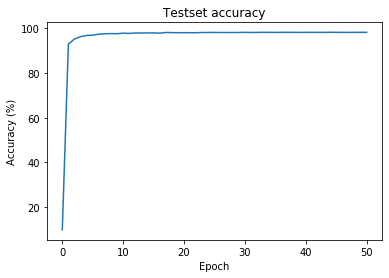

In [0]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

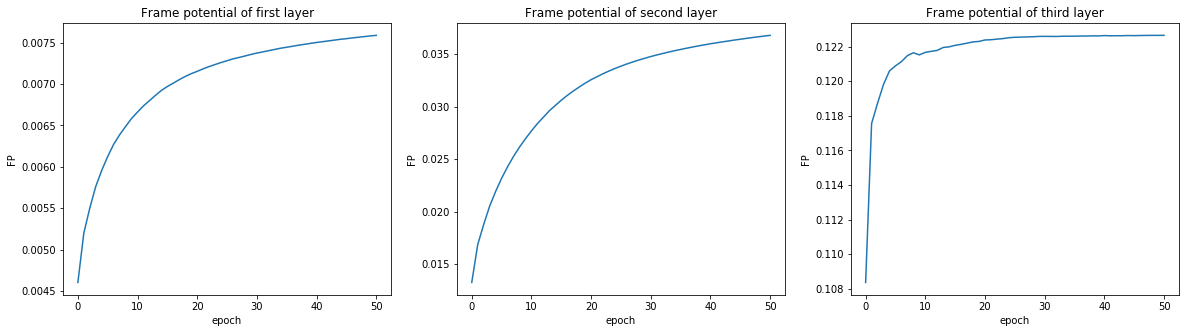

In [0]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['fc1'])
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['fc2'])
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc3'])
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP')

### Pruning LeNet-300-100

#### Pruning the first fully connected layer

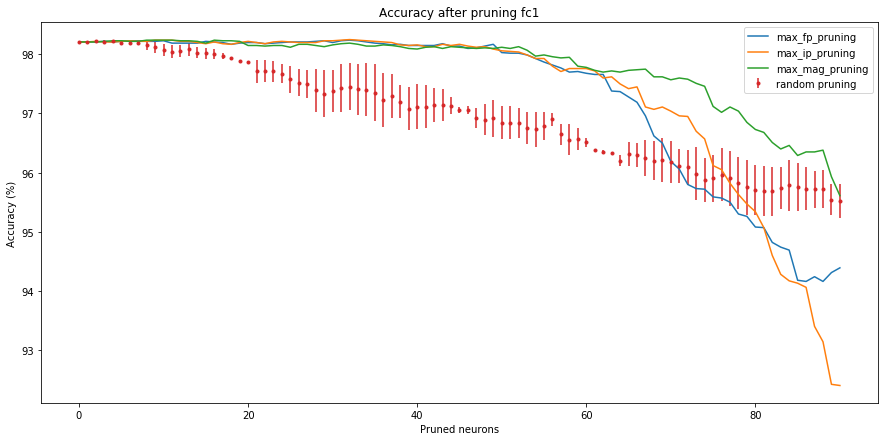

In [0]:
draw_plot(layer, exp_acc, pruning_accuracies, figsize=(15,7), fig_name="")

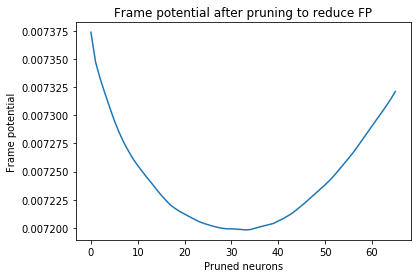

In [0]:
plt.plot(frame_potentials['fc1'])
plt.title('Frame potential after pruning to reduce FP')
plt.xlabel('Pruned neurons')
plt.ylabel('Frame potential')
plt.show()

#### Pruning schedules

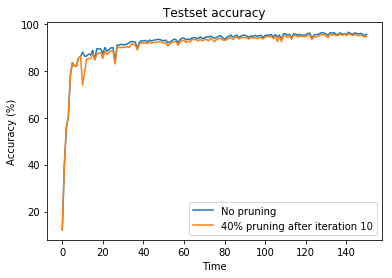

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[10], label="40% pruning after iteration 10")
plt.title('Testset accuracy')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

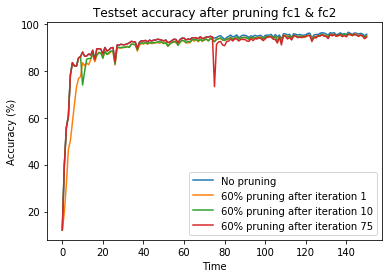

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="60% pruning after iteration 1")
plt.plot(accuracies[10], label="60% pruning after iteration 10")
plt.plot(accuracies[75], label="60% pruning after iteration 75")
plt.title('Testset accuracy after pruning fc1 & fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

### Show images, compare class results

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR-10 / Conv-2

### Loading the data

In [13]:
train_batch_size = 64
test_batch_size = 1000

In [14]:
trainloader, testloader, classes = get_cifar(train_batch_size, test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Training the model

In [0]:
epochs = 10
optim_kwargs = {'lr': 0.0002}

In [0]:
model = Conv2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), **optim_kwargs)
e = Experiment(model, criterion, optimizer, optim_kwargs)
monitored = ['conv1', 'conv2', 'fc1', 'fc2']

In [0]:
test_accuracies, frame_potentials = e.fit(trainloader, testloader, epochs, monitored=monitored, save_results=False)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)

Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.303776
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.684943
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.365785
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.493198
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.192232
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.458461
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.368468
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.346755

Test set: Average loss: 1.1631, Accuracy:   5931/ 10000 (59%)

Train Epoch:   2 [     0/ 50000 (0%)]	Loss: 1.098188
Train Epoch:   2 [  6400/ 50000 (13%)]	Loss: 1.081247
Train Epoch:   2 [ 12800/ 50000 (26%)]	Loss: 0.989488
Train Epoch:   2 [ 19200/ 50000 (38%)]	Loss: 1.161585
Train Epoch:   2 [ 25600/ 50000 (51%)]	Loss: 0.996538
Train Epoch:   2 [ 32000/ 50000 (64%)]	Loss: 1.182470
Train Epoch:   2 [ 38400/ 50000 (77%)]	Loss: 1.067997
Train Epoch:   2 [ 44800/ 50000 (90%)]	Loss: 1.107387

Test set:

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

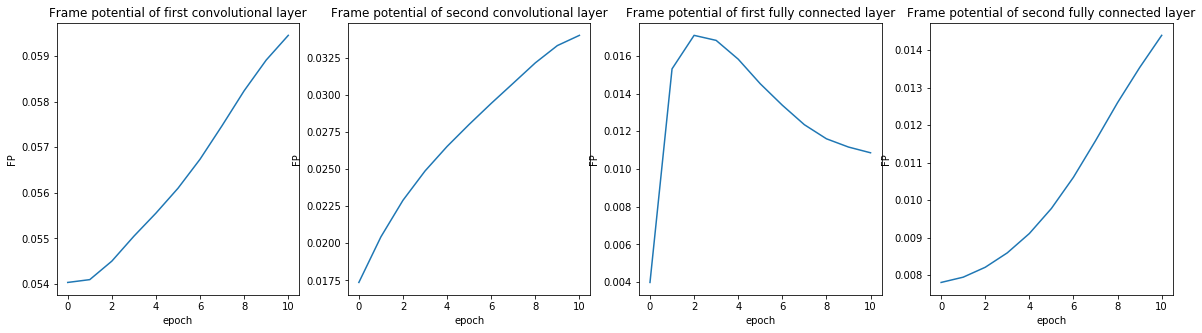

In [0]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['conv1'])
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['conv2'])
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc1'])
ax3.set_title('Frame potential of first fully connected layer')
ax3.set(xlabel='epoch', ylabel='FP')
ax4.plot(frame_potentials['fc2'])
ax4.set_title('Frame potential of second fully connected layer')
ax4.set(xlabel='epoch', ylabel='FP')

### Pruning Conv2

In [0]:
layers = ['fc1', 'fc2']
exp_acc, exp_fps, pruning_accuracies, pruning_fps = cifar_pruning(testloader, layers, pruning_ratio=0.9, include_random=False, n_rounds=2, save_results=True)

Pruning using: max_fp_pruning

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)

Pruning round: [ 10/230 (4%)]

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2412, Accuracy:  

#### Pruning the first fully connected layer

In [21]:
fname_exp_acc = ""
fname_exp_fps = ""
fname_pruning_acc = "out/metrics/pruning/Conv2_fc1_combined_0.9_acc_13-10-2019_14_17_35.npy"
fname_pruning_fps = "out/metrics/pruning/Conv2_fc1_combined_0.9_fp_13-10-2019_14_17_35.npy"

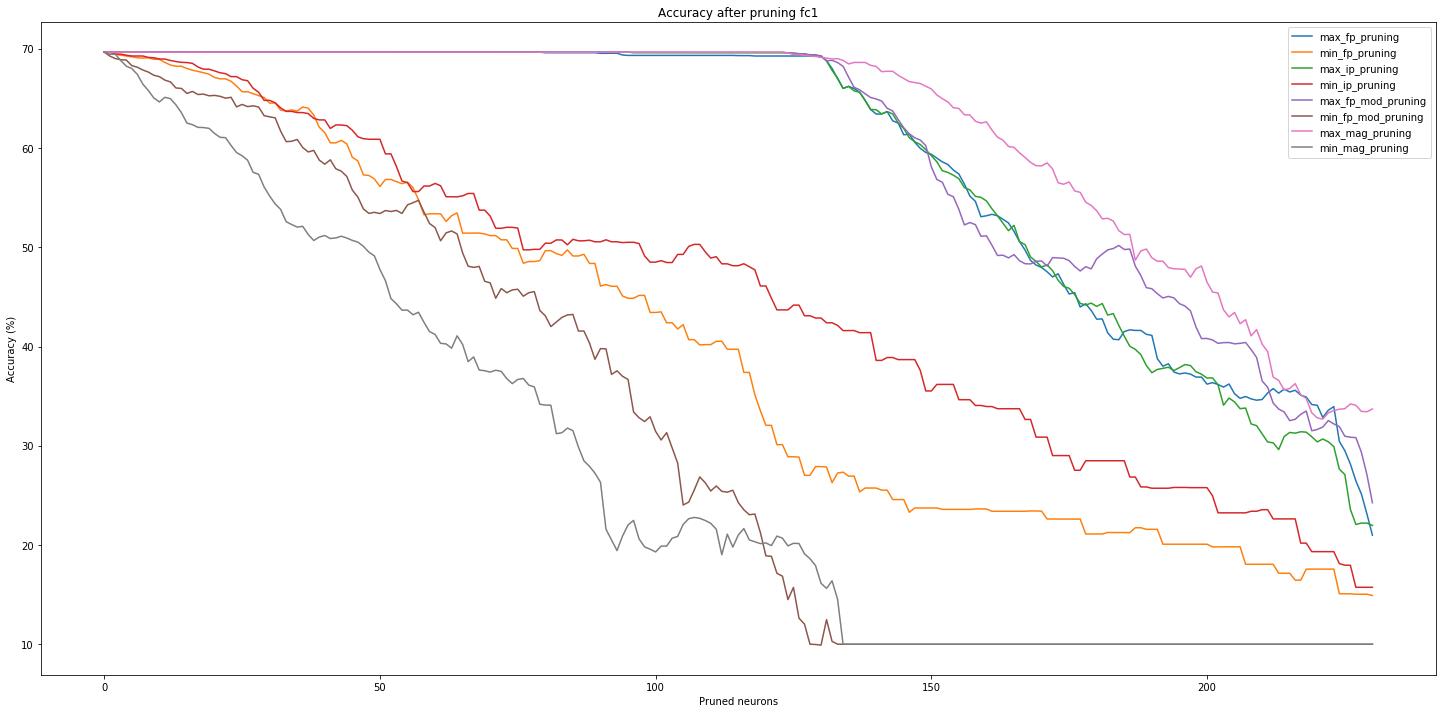

In [25]:
draw_acc_plot("fc1", fname_exp_acc, fname_pruning_acc, fig_name="Conv2_fc1_combined_0.9_acc_13-10-2019_14:17:35")

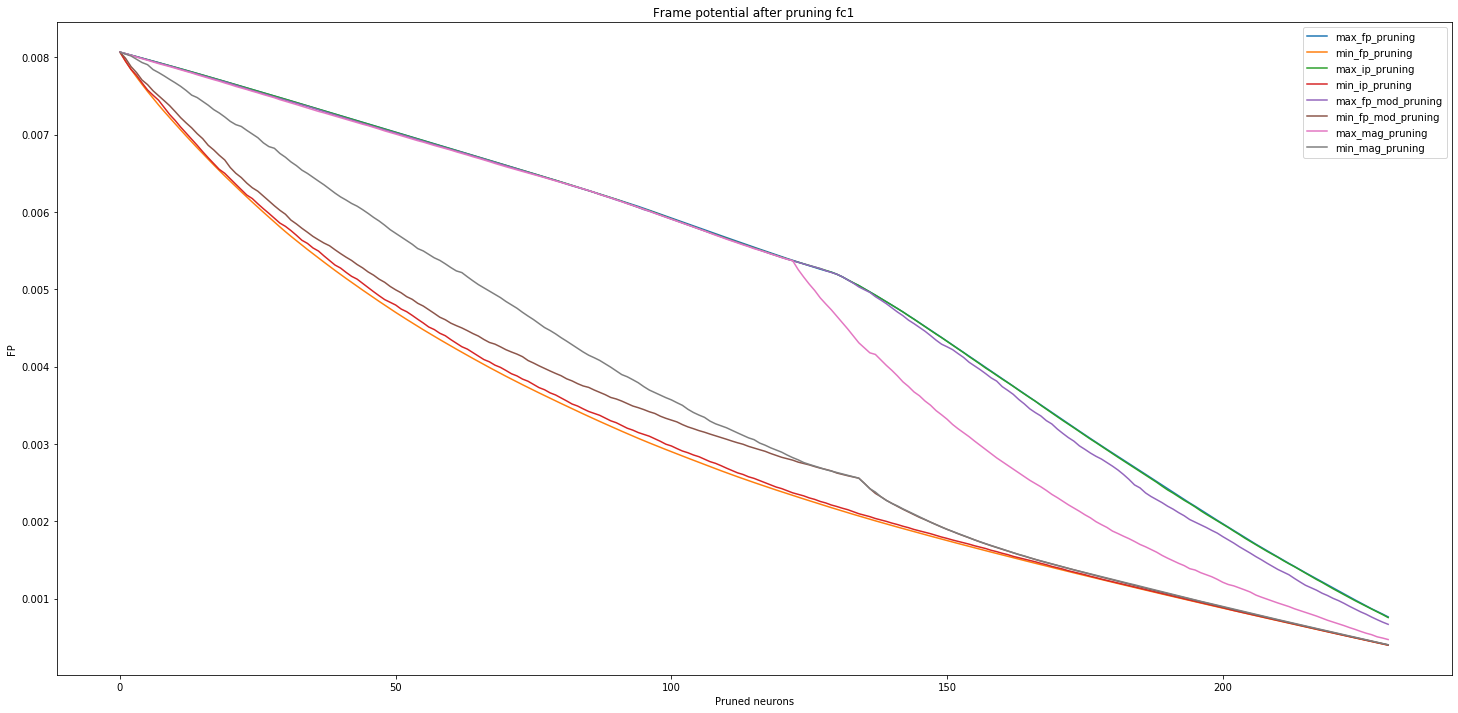

In [26]:
draw_fps_plot('fc1', fname_exp_fps, fname_pruning_fps, fig_name="Conv2_fc1_combined_0.9_fp_13-10-2019_14:17:35")

#### Pruning the first convolutional layer

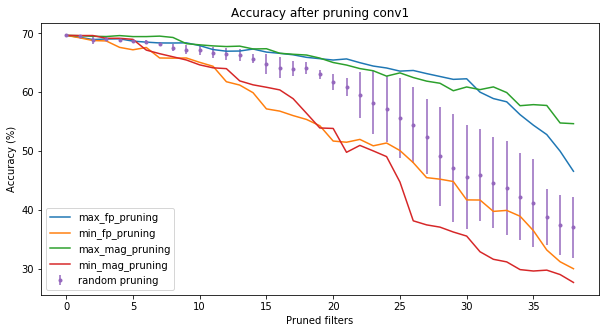

In [0]:
draw_plot(layer, exp_acc, pruning_accuracies, figsize=(10,5), fig_name="")

#### Pruning both fully connected layers

#### Pruning schedules

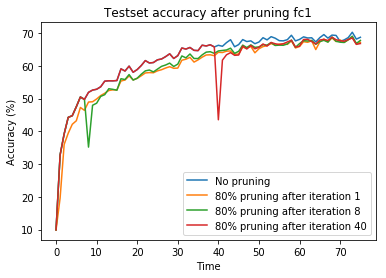

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="80% pruning after iteration 1")
plt.plot(accuracies[8], label="80% pruning after iteration 8")
plt.plot(accuracies[40], label="80% pruning after iteration 40")
plt.title('Testset accuracy after pruning fc1')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

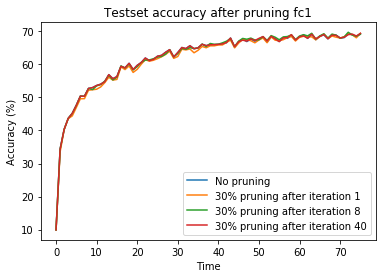

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="30% pruning after iteration 1")
plt.plot(accuracies[8], label="30% pruning after iteration 8")
plt.plot(accuracies[40], label="30% pruning after iteration 40")
plt.title('Testset accuracy after pruning fc1')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

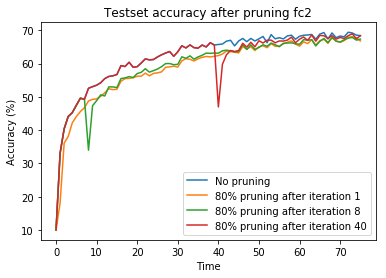

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="80% pruning after iteration 1")
plt.plot(accuracies[8], label="80% pruning after iteration 8")
plt.plot(accuracies[40], label="80% pruning after iteration 40")
plt.title('Testset accuracy after pruning fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

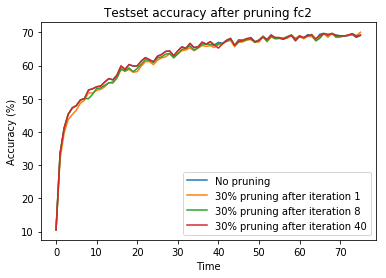

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="30% pruning after iteration 1")
plt.plot(accuracies[8], label="30% pruning after iteration 8")
plt.plot(accuracies[40], label="30% pruning after iteration 40")
plt.title('Testset accuracy after pruning fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

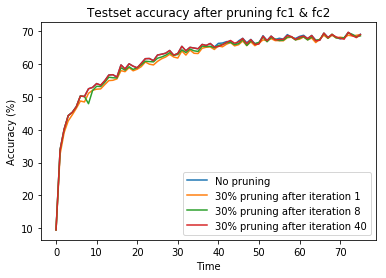

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="30% pruning after iteration 1")
plt.plot(accuracies[8], label="30% pruning after iteration 8")
plt.plot(accuracies[40], label="30% pruning after iteration 40")
plt.title('Testset accuracy after pruning fc1 & fc2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

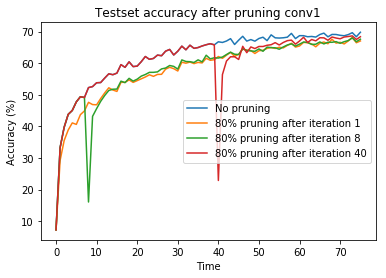

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="80% pruning after iteration 1")
plt.plot(accuracies[8], label="80% pruning after iteration 8")
plt.plot(accuracies[40], label="80% pruning after iteration 40")
plt.title('Testset accuracy after pruning conv1')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

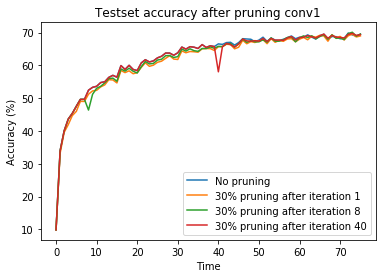

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="30% pruning after iteration 1")
plt.plot(accuracies[8], label="30% pruning after iteration 8")
plt.plot(accuracies[40], label="30% pruning after iteration 40")
plt.title('Testset accuracy after pruning conv1')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

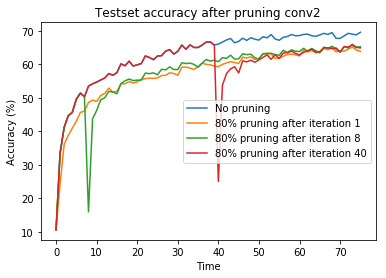

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="80% pruning after iteration 1")
plt.plot(accuracies[8], label="80% pruning after iteration 8")
plt.plot(accuracies[40], label="80% pruning after iteration 40")
plt.title('Testset accuracy after pruning conv2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

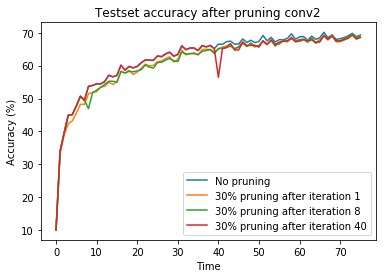

In [0]:
plt.plot(accuracies[0], label="No pruning")
plt.plot(accuracies[1], label="30% pruning after iteration 1")
plt.plot(accuracies[8], label="30% pruning after iteration 8")
plt.plot(accuracies[40], label="30% pruning after iteration 40")
plt.title('Testset accuracy after pruning conv2')
plt.xlabel('Time')
plt.ylabel('Accuracy (%)')
plt.legend(loc="best")
plt.show()

In [16]:
layers = ['fc2']
pruning_ratio = 0.5
accuracies, frame_potentials = cifar_scheduling(testloader, layers, prune.max_fp_mod_pruning, pruning_ratio=pruning_ratio)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)


Test set: Average loss: 2.3038, Accuracy:    996/ 10000 (10%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8126, Accuracy:   3434/ 10000 (34%)


Test set: Average loss: 1.8600, Accuracy:   3329/ 10000 (33%)


Test set: Average loss: 1.9817, Accuracy:   2689/ 10000 (27%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.6719, Accuracy:   4033/ 10000 (40%)


Test set: Average loss: 1.7114, Accuracy:   3900/ 10000 (39%)


Test set: Average loss: 1.7285, Accuracy:   3913/ 10000 (39%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5763, Accuracy:   4366/ 10000 (44%)


Test set: Average loss: 1.6276, Accuracy:   4205/ 10000 (42%)


Test set: Average loss: 1.6418, Accuracy:   4132/ 10000 (41%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5108, Accuracy:   4517/ 10000 (45%)


Test set: Average loss: 1.5305, Accuracy:   4426/ 10000 (44%)


Test set: Avera

({-1: [9.9,
   34.34,
   40.33,
   43.66,
   45.17,
   47.63,
   50.4,
   50.35,
   52.73,
   52.98,
   53.62,
   54.0,
   54.75,
   56.9,
   55.67,
   56.31,
   59.41,
   58.94,
   60.33,
   58.45,
   59.71,
   60.57,
   61.93,
   61.14,
   61.51,
   62.48,
   62.73,
   63.68,
   64.46,
   62.25,
   63.59,
   65.11,
   64.78,
   65.65,
   64.74,
   65.02,
   66.09,
   65.68,
   65.93,
   65.97,
   66.08,
   66.22,
   66.53,
   67.98,
   65.2,
   66.89,
   67.66,
   66.9,
   67.67,
   66.99,
   67.7,
   68.36,
   66.71,
   68.28,
   67.84,
   66.94,
   68.1,
   67.88,
   68.71,
   67.33,
   68.32,
   68.91,
   67.87,
   69.14,
   67.47,
   68.53,
   68.91,
   67.71,
   69.0,
   68.86,
   67.95,
   68.1,
   69.24,
   68.98,
   68.4,
   69.35],
  0: [9.96,
   33.29,
   39.0,
   42.05,
   44.26,
   46.77,
   48.39,
   48.01,
   50.84,
   51.8,
   51.59,
   52.94,
   52.91,
   54.69,
   54.1,
   54.42,
   57.74,
   57.15,
   58.54,
   56.98,
   57.75,
   57.92,
   59.45,
   58.93,
   59.39

In [17]:
layers = ['conv2']
pruning_ratio = 0.5
accuracies, frame_potentials = cifar_scheduling(testloader, layers, prune.max_fp_mod_pruning, pruning_ratio=pruning_ratio)


Test set: Average loss: 2.3040, Accuracy:   1094/ 10000 (11%)


Test set: Average loss: 2.3035, Accuracy:   1065/ 10000 (11%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8339, Accuracy:   3380/ 10000 (34%)


Test set: Average loss: 1.8934, Accuracy:   3188/ 10000 (32%)


Test set: Average loss: 1.9994, Accuracy:   2801/ 10000 (28%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.7122, Accuracy:   3944/ 10000 (39%)


Test set: Average loss: 1.7799, Accuracy:   3707/ 10000 (37%)


Test set: Average loss: 1.7456, Accuracy:   3811/ 10000 (38%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5717, Accuracy:   4316/ 10000 (43%)


Test set: Average loss: 1.6613, Accuracy:   4043/ 10000 (40%)


Test set: Average loss: 1.6455, Accuracy:   4069/ 10000 (41%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5278, Accuracy:   4440/ 10000 (44%)


Test set: Average loss: 1.5904, Accuracy:   4223/ 10000 (42%)


Test set: Avera

In [18]:
layers = ['conv1']
pruning_ratio = 0.5
accuracies, frame_potentials = cifar_scheduling(testloader, layers, prune.max_fp_mod_pruning, pruning_ratio=pruning_ratio)


Test set: Average loss: 2.3026, Accuracy:   1199/ 10000 (12%)


Test set: Average loss: 2.3032, Accuracy:   1091/ 10000 (11%)

Evaluating model accuracies [  1/ 75]

Test set: Average loss: 1.8262, Accuracy:   3334/ 10000 (33%)


Test set: Average loss: 1.8861, Accuracy:   3100/ 10000 (31%)


Test set: Average loss: 1.9968, Accuracy:   2864/ 10000 (29%)

Evaluating model accuracies [  2/ 75]

Test set: Average loss: 1.7107, Accuracy:   3914/ 10000 (39%)


Test set: Average loss: 1.7351, Accuracy:   3870/ 10000 (39%)


Test set: Average loss: 1.7404, Accuracy:   3798/ 10000 (38%)

Evaluating model accuracies [  3/ 75]

Test set: Average loss: 1.5736, Accuracy:   4448/ 10000 (44%)


Test set: Average loss: 1.6298, Accuracy:   4208/ 10000 (42%)


Test set: Average loss: 1.6440, Accuracy:   4112/ 10000 (41%)

Evaluating model accuracies [  4/ 75]

Test set: Average loss: 1.5050, Accuracy:   4569/ 10000 (46%)


Test set: Average loss: 1.5501, Accuracy:   4468/ 10000 (45%)


Test set: Avera

### Show images, compare class results

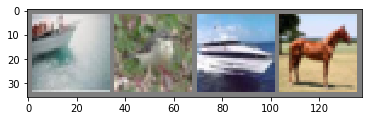

 ship  bird  ship horse


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 69 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
